# [Blog title]
Hiro Naito

## Preps

In [4]:
# Libraries 

import pandas as pd
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Gaussian

from econml.metalearners import SLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
import dowhy
from dowhy import CausalModel
from dowhy import gcm
import networkx as nx

from econml.dml import DML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from econml.metalearners import TLearner

In [5]:
def create_graph(causal_matrix: pd.DataFrame): 
    G = nx.DiGraph()
    G.add_nodes_from(causal_matrix.columns.to_list())
    for i, row in enumerate(causal_matrix.index):
        for j, col in enumerate(causal_matrix.columns):
            weight = causal_matrix.iloc[i, j]
            if weight != 0.0:  # Add an edge only if the weight is non-zero
                G.add_edge(row, col, weight=weight)

    return G

def create_synth_data(G : nx.DiGraph, causal_matrix: pd.DataFrame, n: int, binaries: list[str] = []):
    #Get list of nodes in topolocial order
    topological_sorted = list(nx.topological_sort(G))

    df = pd.DataFrame()
    for node in topological_sorted:
        if node in binaries:
            values = np.zeros(n)
            for predecessor in G.predecessors(node):
                values += df[predecessor] * causal_matrix.at[predecessor,node]
            p = 1 / (1 + np.exp(-1.0 * values))
            values = np.random.binomial(1,p,n)
        else:
            values = np.random.normal(0,1,n)
            for predecessor in G.predecessors(node):
                values += df[predecessor] * causal_matrix.at[predecessor,node]
        df[node] = values
    return df

In [6]:
#Synthetic data size
n = 10000

#Fixing seed
random_state=123

## Part 1 - Mediators

### Simple example with a mediator
__Example scenarios:__
   * __Education: After-School Tutoring__
      * __Treatment (T):__ Enrollment in an after-school tutoring program.
      * __Mediator (M):__ # of hours to study in a week.
      * __Outcome (Y):__  GPA (Grade Point Average).
   * __Mental Health: Cognitive Behavioral Therapy (CBT)__
      * __Treatment (T):__ Joining Cognitive Behavioral Therapy (CBT).
      * __Mediator (M):__ Frequency of negative thought pattern.
      * __Outcome (Y):__ Mental health score from survey.
   * __Marketing: Advertising Campaign__
       * __Treatment (T):__ Exposure to an advertising campaign.
       * __Mediator (M):__ Product awareness.
       * __Outcome (Y):__ Product sales.

In [87]:
# Create causal matrix and create graph + synthetic data based on the matrix

#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship
causal_matrix = pd.DataFrame([
    {"node_from": "T", "T": 0.0, "Y": 0.0, "M": 2.0},
    {"node_from": "Y", "T": 0.0, "Y": 0.0, "M": 0.0},
    {"node_from": "M", "T": 0.0, "Y": 4.0, "M": 0.0}
])
causal_matrix.set_index('node_from',inplace=True)

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)

#Create synthetic data with the relationship specified

T = np.random.binomial(1,0.5,n)
M = 2.0 * T + np.random.normal(0,1,n)
Y = 4.0 * M + np.random.normal(0,1,n)

df = pd.DataFrame({'T':T,'M':M,'Y':Y})
print(df)

      T         M          Y
0     0 -0.392114  -1.844807
1     1  3.286656  12.462984
2     0  0.413490  -0.217679
3     0 -0.970275  -4.542176
4     1  2.831050  12.029173
...  ..       ...        ...
9995  1  1.362648   4.325996
9996  0 -0.054482  -1.014050
9997  0  0.628919   3.418099
9998  0  0.151407   0.214979
9999  0  1.155966   4.698497

[10000 rows x 3 columns]


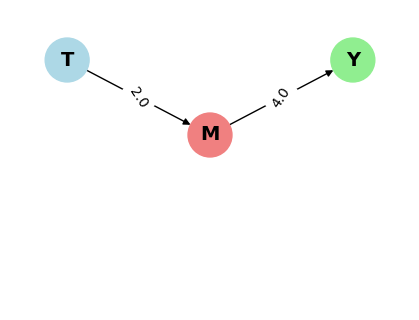

In [10]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'Y':(1,0), 'M':(0.5,-0.3)}
pos = nx.spring_layout(G, k=0.1, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "M" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=14, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [11]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          16.749
Method:                          IRLS   Log-Likelihood:                -28280.
Date:                Mon, 09 Sep 2024   Deviance:                   1.6746e+05
Time:                        10:44:06   Pearson chi2:                 1.67e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6061
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0985      0.058      1.691      0.0

In [12]:
#Estimate effect by regressing on outcome using both treatment and mediator variable

formula = 'Y ~ T + M'
glm_model = smf.glm(formula=formula, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                         0.98753
Method:                          IRLS   Log-Likelihood:                -14125.
Date:                Mon, 09 Sep 2024   Deviance:                       9872.4
Time:                        10:44:06   Pearson chi2:                 9.87e+03
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0058      0.014      0.409      0.6

### Simple example + adding an arrow T -> Y
__Example scenarios:__
   * __Education: Classroom Technology__
      * __Treatment (T):__ Introduction of interactive technology in the classroom.
      * __Mediator (M):__ Increase in student engagement.
      * __Outcome (Y):__ Improvement in academic performance.
   * __Mental Health: Mental Health: Antidepressant Medication__
      * __Treatment (T):__ Use of antidepressant medication.
      * __Mediator (M):__ Improvement in mood or cognitive function.
      * __Outcome (Y):__ Reduction in depression symptoms.
   * __Economics: Financial Incentive Program__
       * __Treatment (T):__ Provision of financial incentives to workers.
       * __Mediator (M):__  Increase in worker productivity.
       * __Outcome (Y):__ Increase in company profits.

In [14]:
# Create causal matrix and create graph + synthetic data based on the matrix


#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship
causal_matrix = pd.DataFrame([
    {"node_from": "T", "T": 0.0, "Y": 1.0, "M": 2.0},
    {"node_from": "Y", "T": 0.0, "Y": 0.0, "M": 0.0},
    {"node_from": "M", "T": 0.0, "Y": 4.0, "M": 0.0}
])
causal_matrix.set_index('node_from',inplace=True)

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)



#Define which variables have binary outcome
binaries = ['T']

#Create synthetic data based on graph and causal_matrix
df = create_synth_data(G, causal_matrix, n, binaries)

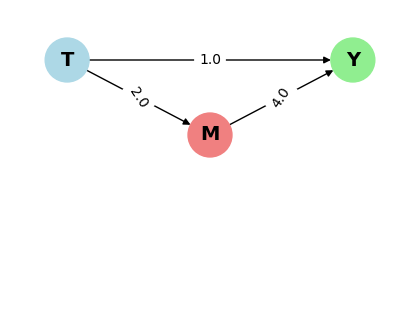

In [15]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'Y':(1,0), 'M':(0.5,-0.3)}
pos = nx.spring_layout(G, k=0.1, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "M" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=14, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [16]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          16.851
Method:                          IRLS   Log-Likelihood:                -28310.
Date:                Mon, 09 Sep 2024   Deviance:                   1.6847e+05
Time:                        10:44:06   Pearson chi2:                 1.68e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7057
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0331      0.058     -0.571      0.5

In [17]:
#Estimate effect by regressing on outcome using both treatment and mediator variable

formula1 = 'Y ~ T + M'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                          1.0181
Method:                          IRLS   Log-Likelihood:                -14277.
Date:                Mon, 09 Sep 2024   Deviance:                       10178.
Time:                        10:44:06   Pearson chi2:                 1.02e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0068      0.014      0.480      0.6

### Two mediators example
__Example scenarios:__
   * __Economics: Financial Literacy Training__
     * __Treatment (T):__ Participation in a financial literacy training program.
     * __Mediator 1 (M1):__ Improvement in budgeting skills.
     * __Mediator 2 (M2):__ Increase in savings behavior.
     * __Outcome (Y):__ Increase in financial stability.
   * __Public Health: Weight Loss Program__
      * __Treatment (T):__ Enrollment in a weight loss program.
      * __Mediator 1 (M1):__ Increase in physical activity.
      * __Mediator 2 (M2):__ Improvement in dietary habits.
      * __Outcome (Y):__ Reduction in body mass index (BMI).
   * __Marketing: Multi-Channel Advertising Campaign__
      * __Treatment (T):__ Exposure to a multi-channel advertising campaign.
      * __Mediator 1 (M1):__ Increase in brand awareness.
      * __Mediator 2 (M2):__ Improvement in brand perception.
      * __Outcome (Y):__ Increase in product sales

In [19]:
# Create causal matrix and create graph + synthetic data based on the matrix


#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship
causal_matrix = pd.DataFrame([
    {"node_from": "T", "T": 0.0, "Y": 0.0, "M1": 2.0, "M2": 1.0},
    {"node_from": "Y", "T": 0.0, "Y": 0.0, "M1": 0.0, "M2": 0.0},
    {"node_from": "M1", "T": 0.0, "Y": 4.0, "M1": 0.0, "M2": 0.0},
    {"node_from": "M2", "T": 0.0, "Y": 3.0, "M1": 0.0, "M2": 0.0},

])
causal_matrix.set_index('node_from',inplace=True)

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)

#Define which variables have binary outcome
binaries = ['T']

#Create synthetic data based on graph and causal_matrix
df = create_synth_data(G, causal_matrix, n, binaries)

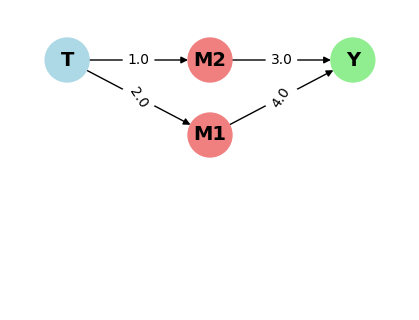

In [20]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'Y':(1,0), 'M1':(0.5,-0.3), 'M2': (0.5, 0)}
pos = nx.spring_layout(G, k=0.1, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "M" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=14, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [21]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          25.817
Method:                          IRLS   Log-Likelihood:                -30444.
Date:                Mon, 09 Sep 2024   Deviance:                   2.5812e+05
Time:                        10:44:06   Pearson chi2:                 2.58e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6957
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0337      0.072     -0.467      0.6

In [22]:
#Estimate effect by regressing on outcome using both treatment and mediator variables

formula1 = 'Y ~ T + M1 + M2'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9996
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                          1.0100
Method:                          IRLS   Log-Likelihood:                -14237.
Date:                Mon, 09 Sep 2024   Deviance:                       10096.
Time:                        10:44:06   Pearson chi2:                 1.01e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0130      0.014      0.912      0.3

### Complex example

In [24]:
# Import causal matrix and create graph + synthetic data based on the matrix


causal_matrix = pd.read_csv("Dont add all features - Mediator.csv", index_col=0)
causal_matrix.fillna(0.0,inplace=True)
#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)

#Define which variables have binary outcome
binaries = ['T']

#Create synthetic data based on graph and causal_matrix
df = create_synth_data(G, causal_matrix, n, binaries)

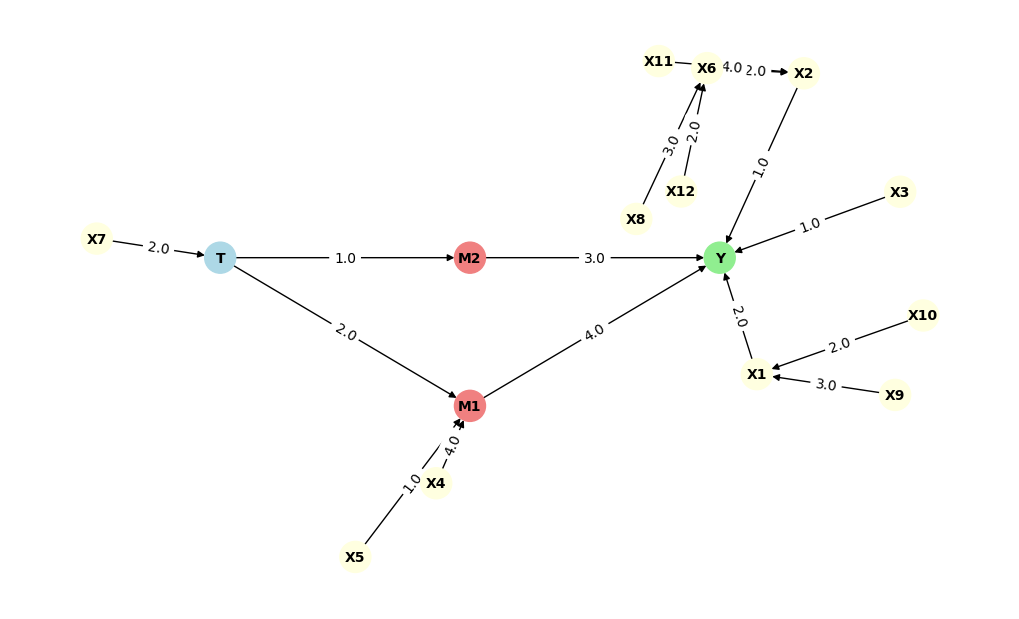

In [25]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'Y':(1,0), 'M1':(0.5,-0.3), 'M2': (0.5, 0)}
pos = nx.spring_layout(G, k=0.2, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "M" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(10,6))
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


#plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
#plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [26]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          425.69
Method:                          IRLS   Log-Likelihood:                -44457.
Date:                Mon, 09 Sep 2024   Deviance:                   4.2560e+06
Time:                        10:44:07   Pearson chi2:                 4.26e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.06255
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1371      0.294      0.467      0.6

In [27]:
#Estimate effect by regressing on outcome using all variables

formula1 = 'Y ~ T + M1 + M2 + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9984
Model Family:                Gaussian   Df Model:                           15
Link Function:               Identity   Scale:                          1.0027
Method:                          IRLS   Log-Likelihood:                -14195.
Date:                Mon, 09 Sep 2024   Deviance:                       10011.
Time:                        10:44:07   Pearson chi2:                 1.00e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0278      0.016      1.702      0.0

In [ ]:
#Create train & test data
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(df.drop(columns=['T','Y']), df['T'],df['Y'], test_size=0.2, random_state=random_state)

In [28]:
#Estimate using T-learner and using Random Forest as the underlying model

#Define and train model(s). 
t_learner = TLearner(models = LGBMRegressor(n_estimators=100, random_state=random_state))
t_learner.fit(Y_train, T_train, X=X_train)

#Calculate CATE (Conditional Average Treatment Effect) for the test set
cate = t_learner.effect(X_test)

#Calculate ATE (Average treatment effect) by taking average 
ate = np.mean(cate)
print(f"\nEstimated Average Treatment Effect (ATE): {ate}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 14
[LightGBM] [Info] Start training from score 0.151574
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 4050, number of used features: 14
[LightGBM] [Info] Start training from score 10.718136
fit complete
Estimated CATE for the first few samples:
[-0.27738731  1.0797598   2.40444492  2.62900697  3.18592453  0.79694245
  5.20879451 -3.28280817  1.04216377  2.56480237]

Estimated Average Treatment Effect (ATE): 0.5741855630017246


In [29]:
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression

#Estimate using DML and using Random Forest as the underlying model

dml = DML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_t=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_final=StatsModelsLinearRegression(),
    cv=3,
    random_state=random_state
)

# Fit the DML model
dml.fit(Y_train, T_train, X=X_train)
# Estimate the Conditional Average Treatment Effect (CATE)
cate = dml.effect(X_test)

# Print the estimated CATE for the first few samples
print("Estimated CATE for the first few samples:")
print(cate[:10])

# Optionally, you can also estimate the Average Treatment Effect (ATE) by averaging the CATE
ate = np.mean(cate)
print(f"\nEstimated Average Treatment Effect (ATE): {ate}")

Estimated CATE for the first few samples:
[ 0.41734866  0.54574989  0.30709583  0.54017103  0.22677871  0.6207967
  0.08715282 -0.2471757   0.01737686  0.26454937]

Estimated Average Treatment Effect (ATE): 0.29065107183058064


The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


## (To be used later on)

In [31]:
n = 1000

X = np.random.normal(0, 1, n)

T = 0.5 * X + np.random.normal(0, 1, n)

Y = 2 * T + 0.3 * X + np.random.normal(0, 1, n)

Z = 5 * T + 0.5 * X + np.random.normal(0, 1, n)

A = np.random.normal(0, 1, n)
B = np.random.normal(0, 1, n)


In [32]:
df = pd.DataFrame({'Y': Y, 'T': T, 'X': X, 'Z': Z, 'A':A, 'B':B})

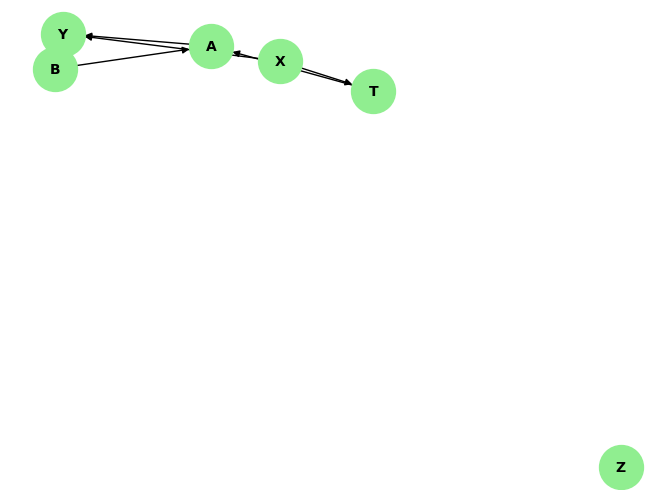

In [33]:
nodes = ['X','Y','Z','T','A','B']


edges = []
edges += [('A','Y'), ('X','Y'), ('X','T')]
edges += [('T','A')]
edges += [('B','A'),('B','Y')]
G=nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# pos = nx.spring_layout(G,k=5)  # Position nodes using Fruchterman-Reingold force-directed algorithm
# pos[target_outcome] = (2,0)
# pos[target_treatment] = (0.5,0)
# node_colors = ['lightgreen' if node == target_treatment else 'lightcoral' if node == target_outcome else 'lightblue' for node in G.nodes]
nx.draw(G, with_labels=True, node_color='lightgreen',node_size=1000, font_size=10, font_weight='bold', arrows=True)
plt.show()

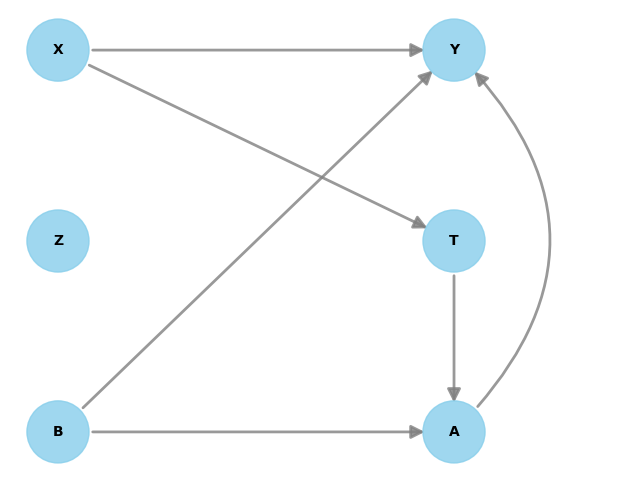

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|X])
d[T]        
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,X,U) = P(Y|T,X)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [34]:
#Create model 
model = CausalModel(
    data=df,
    treatment='T',
    outcome='Y',
    graph = "\n".join(nx.generate_gml(G))
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

Without conditioning on Z:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     5050.
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        10:44:56   Log-Likelihood:                -1443.7
No. Observations:                1000   AIC:                             2891.
Df Residuals:                     998   BIC:                             2901.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028    

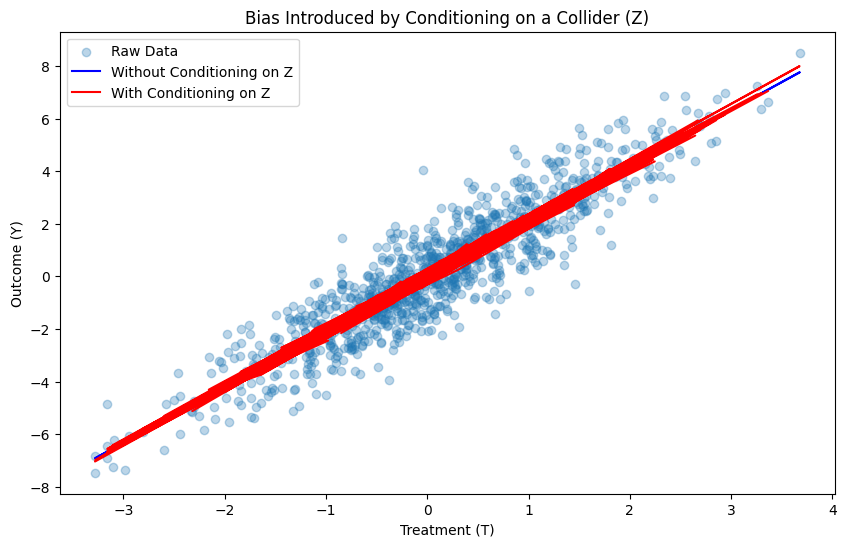

In [35]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n = 1000

# Simulate exogenous variable X
X = np.random.normal(0, 1, n)

# Simulate treatment variable T influenced by X
T = 0.5 * X + np.random.normal(0, 1, n)

# Simulate outcome variable Y influenced by T and X
Y = 2 * T + 0.3 * X + np.random.normal(0, 1, n)

# Simulate collider variable Z influenced by T and X
Z = 5 * T + 0.5 * X + np.random.normal(0, 1, n)

# Estimate causal effect of T on Y without conditioning on Z
model_no_z = sm.OLS(Y, sm.add_constant(T)).fit()
print("Without conditioning on Z:")
print(model_no_z.summary())

# Estimate causal effect of T on Y with conditioning on Z
data = pd.DataFrame({'Y': Y, 'T': T, 'X': X, 'Z': Z})
model_with_z = sm.OLS(data['Y'], sm.add_constant(data[['T', 'Z']])).fit()
print("\nWith conditioning on Z:")
print(model_with_z.summary())

# Visualizing the bias introduced by conditioning on Z
plt.figure(figsize=(10, 6))
plt.scatter(T, Y, alpha=0.3, label='Raw Data')
plt.xlabel('Treatment (T)')
plt.ylabel('Outcome (Y)')

# Plot the regression line without conditioning on Z
plt.plot(T, model_no_z.predict(sm.add_constant(T)), color='blue', label='Without Conditioning on Z')

# Plot the regression line with conditioning on Z
plt.plot(T, model_with_z.predict(sm.add_constant(data[['T', 'Z']])), color='red', label='With Conditioning on Z')

plt.legend()
plt.title('Bias Introduced by Conditioning on a Collider (Z)')
plt.show()

In [36]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial

# Set a random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n = 10000

# Collider 1
T = np.random.normal(1,1,n)
A = np.random.normal(2,3,n)
X = 10 * T + 2.0 * A + np.random.normal(0,1,n)
Y = 2 * X + np.random.normal(0,1,n)

# # Collider 2
# T = np.random.normal(1,1,n)
# Y = 5.0 * T + np.random.normal(0,1,n)
# X = 2.0 * Y + 1.0 * T + np.random.normal(0,1,n)
# A = np.random.normal(2,3,n) #This is not actually used



# Create a DataFrame
df = pd.DataFrame({'Y': Y, 'T': T, 'A': A, 'X': X})
formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()

# Print the summary of the model
print(glm_results.summary())


formula = 'Y ~ T + A'
glm_model = smf.glm(formula=formula, data=df, family=Gaussian())
glm_results = glm_model.fit()

# Print the summary of the model
print(glm_results.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          150.85
Method:                          IRLS   Log-Likelihood:                -39270.
Date:                Mon, 09 Sep 2024   Deviance:                   1.5082e+06
Time:                        10:44:56   Pearson chi2:                 1.51e+06
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9296
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1896      0.173     47.279      0.0

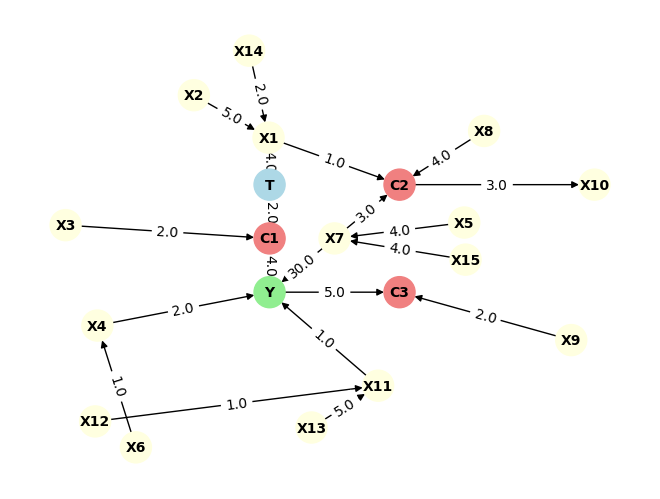

In [37]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the causal effect matrix from a CSV file
causal_matrix = pd.read_csv("causal_chart.csv", index_col=0)
causal_matrix.fillna(0.0,inplace=True)
# Create a directed graph
G = nx.DiGraph()

# Add nodes (optional: you can explicitly add nodes if you want to control their order)
G.add_nodes_from(causal_matrix.columns)

# Add edges with weights based on the matrix values
for i, row in enumerate(causal_matrix.index):
    for j, col in enumerate(causal_matrix.columns):
        weight = causal_matrix.iloc[i, j]
        if weight != 0:  # Add an edge only if the weight is non-zero
            G.add_edge(row, col, weight=weight)

# Draw the graph
#pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
fixed_positions = {'T':(0,0), 'Y':(0,-4), 'C1':(0,-2),'C2':(2,0),'C3':(2,-4), 'X7':(1,-2), 'X10':(5,0)}
pos = nx.spring_layout(G, k=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "C" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    

nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

In [38]:

n = n

#Get list of nodes in topolocial order
topological_sorted = list(nx.topological_sort(G))


df = pd.DataFrame()
for node in topological_sorted:
    values = np.random.normal(0,1,n)
    for predecessor in G.predecessors(node):
        values += df[predecessor] * causal_matrix.at[predecessor,node]
    df[node] = values
    
df

X2        X3        X5        X6        X8        X9       X12  \
0     0.064956  1.148625 -0.160422 -1.688528  1.635939 -0.948610  0.956677   
1    -1.478855 -0.245927  1.168463  0.079579  0.280559 -1.078770  0.487476   
2    -0.700877 -0.153323  0.707305 -1.159024  1.106368 -0.860724 -0.207121   
3    -0.706819 -0.087947 -0.117243 -0.605083  0.181313  1.118637 -1.468015   
4    -0.266956 -1.823688 -1.243987  0.706711 -1.046472 -0.276401  0.448535   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.760832  0.806132  0.870891 -0.562606  0.228159  0.005780  0.700672   
9996  0.399053 -0.539608  0.382472 -0.149556  1.677746 -0.010402 -0.714273   
9997 -1.959983  0.283833 -0.903602 -0.060827  1.480298 -2.033002  0.355126   
9998 -0.701753  0.151735  1.012101 -1.380442  1.487202  0.715841  1.117075   
9999 -0.100130  2.191888 -0.319731  0.609362  1.412392  0.834521 -0.414153   

           X13       X14       X15        X4        X11         X1         X7  \
0    -0.548105 -0.413853  1.013125 -1.929076  -1.651562  -0.580629   2.954066   
1     0.692034  1.608981 -0.121594  0.012672   2.884365  -3.836496   3.511286   
2     1.313985  0.851183 -1.042014 -0.106917   6.111400  -0.400306  -0.881336   
3     0.156624  0.351482  0.170766  0.462922  -0.635663  -1.798654  -1.821592   
4    -1.295324 -0.153748  0.622056  1.072898  -5.624963  -1.231066  -3.434846   
...        ...       ...       ...       ...        ...        ...        ...   
9995 -2.485509 -2.030520  1.978699  0.288336 -12.828762  -7.364759  10.186696   
9996 -0.945855 -0.854925 -0.674263  0.368825  -4.395734   0.766856   0.379643   
9997  0.868046 -0.883693 -0.369619  0.901543   3.592024 -11.040390  -3.822325   
9998 -0.804051  0.194022  1.399274 -1.262064  -1.724298  -3.587839  10.252155   
9999 -1.103360  0.008121  1.507374  0.201784  -5.894162  -0.362947   5.872856   

              T         C2         C1         X10           Y           C3  
0     -3.959700  16.267771  -5.939865   48.855815   59.006078   292.764289  
1    -15.887537   6.541901 -31.094090   18.546166  -16.018839   -83.108006  
2     -1.784240   2.626040  -3.029392    6.322531  -33.087319  -165.867143  
3     -6.044555  -6.956408 -13.489023  -21.541454 -109.444303  -544.078351  
4     -6.239960 -16.031064 -15.603089  -47.532839 -169.447923  -848.415474  
...         ...        ...        ...         ...         ...          ...  
9995 -32.156167  23.408469 -63.396878   69.497412   40.673348   204.451584  
9996   3.200253   8.965451   5.041455   26.860202   28.189452   140.850559  
9997 -43.561727 -16.168382 -87.415077  -48.130369 -459.703706 -2302.224018  
9998 -15.267661  34.034762 -29.818568  100.675872  184.943629   924.099478  
9999  -2.017521  23.417231   1.467327   69.436796  176.823622   888.347723  

[10000 rows x 20 columns]

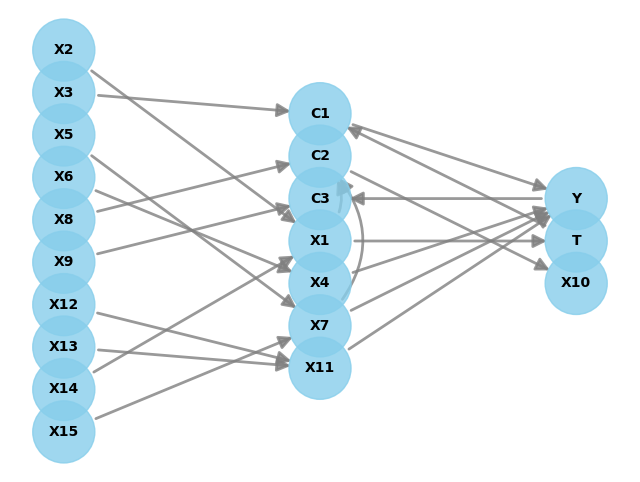

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[T]      
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,,U) = P(Y|T,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                     -1⎤
 ⎢  d      ⎛  d       ⎞  ⎥
E⎢─────(Y)⋅⎜─────([T])⎟  ⎥
 ⎣d[X₁]    ⎝d[X₁]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{X1})
Estimand assumption 2, Exclusion: If we remove {X1}→{T}, then ¬({X1}→Y)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡  d       d        ⎤
E⎢─────(Y)⋅────([C₁])⎥
 ⎣d[C₁]    d[T]      ⎦
Estimand assumption 1, Full-mediation: C1 intercepts (blocks) all directed paths from T to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{T} and U→{C1} then P(C1|T,U) = P(C1|T)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{C1} and U→Y then P(Y|C1, T, U) = P(Y|C1, T)



In [39]:
#Create model 
model = CausalModel(
    data=df,
    treatment='T',
    outcome='Y',
    graph = "\n".join(nx.generate_gml(G))
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

In [40]:
formula1 = 'Y ~ T + X2 + X4 + X5 + X7 + X11'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()

# Print the summary of the model
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9993
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                          82.183
Method:                          IRLS   Log-Likelihood:                -36231.
Date:                Mon, 09 Sep 2024   Deviance:                   8.2125e+05
Time:                        10:44:57   Pearson chi2:                 8.21e+05
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0194      0.091     -0.214      0.8

In [41]:
formula = 'Y ~ T + C2 + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12 + X13 + X14 + X15'
#formula = 'Y ~ T + C1 + C2 + C3 + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X9 + X11 + X12 + X13 + X14 + X15'

glm_model = smf.glm(formula=formula, data=df, family=Gaussian())
glm_results = glm_model.fit()

# Print the summary of the model
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9982
Model Family:                Gaussian   Df Model:                           17
Link Function:               Identity   Scale:                          17.103
Method:                          IRLS   Log-Likelihood:                -28377.
Date:                Mon, 09 Sep 2024   Deviance:                   1.7072e+05
Time:                        10:44:57   Pearson chi2:                 1.71e+05
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0390      0.041     -0.942      0.3

In [42]:
formula1 = 'Y ~ T + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12 + X13'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()

# Print the summary of the model
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9985
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                          17.099
Method:                          IRLS   Log-Likelihood:                -28377.
Date:                Mon, 09 Sep 2024   Deviance:                   1.7074e+05
Time:                        10:44:57   Pearson chi2:                 1.71e+05
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0387      0.041     -0.935      0.3

In [43]:
dml = DML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_t=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_final=LassoCV(),
    cv=3,
    random_state=random_state
)

# Split the data into training and testing sets
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(df.drop(columns=['T','Y']), df['T'],df['Y'], test_size=0.2, random_state=random_state)


# Fit the DML model
dml.fit(Y_train, T_train, X=X_train)

# Estimate the Conditional Average Treatment Effect (CATE)
cate = dml.effect(X_test)

# Print the estimated CATE for the first few samples
print("Estimated CATE for the first few samples:")
print(cate[:10])

# Optionally, you can also estimate the Average Treatment Effect (ATE) by averaging the CATE
ate = np.mean(cate)
print(f"\nEstimated Average Treatment Effect (ATE): {ate}")

Estimated CATE for the first few samples:
[-3.07046055e-16  5.01335085e-16  7.97972799e-17  1.47451495e-16
  4.73579509e-16  9.54097912e-17  2.67147415e-16 -1.61329283e-16
  5.39499001e-16 -1.73472348e-18]

Estimated Average Treatment Effect (ATE): 4.85202156230713e-18


The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


In [44]:
dml = DML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_t=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_final=LassoCV(),
    cv=3,
    random_state=random_state
)

# Split the data into training and testing sets
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(df.drop(columns=['T','Y','C1','C3']), df['T'],df['Y'], test_size=0.2, random_state=random_state)


# Fit the DML model
dml.fit(Y_train, T_train, X=X_train)

# Estimate the Conditional Average Treatment Effect (CATE)
cate = dml.effect(X_test)

# Print the estimated CATE for the first few samples
print("Estimated CATE for the first few samples:")
print(cate[:10])

# Optionally, you can also estimate the Average Treatment Effect (ATE) by averaging the CATE
ate = np.mean(cate)
print(f"\nEstimated Average Treatment Effect (ATE): {ate}")

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3567.771134952549, tolerance: 286.9314798886186
Objective did not converge. You might want to increase the number of iterations. Duality gap: 14348.420023884159, tolerance: 286.9314798886186
Objective did not converge. You might want to increase the number of iterations. Duality gap: 26770.499008427374, tolerance: 286.9314798886186
Objective did not converge. You might want to increase the number of iterations. Duality gap: 38561.34165613237, tolerance: 286.9314798886186
Objective did not converge. You might want to increase the number of iterations. Duality gap: 48964.145139347995, tolerance: 286.9314798886186
Objective did not converge. You might want to increase the number of iterations. Duality gap: 57683.98307970213, tolerance: 286.9314798886186
Objective did not converge. You might want to increase the number of iterations. Duality gap: 64653.633135310374, tolerance: 286.9314798886186
Ob

Estimated CATE for the first few samples:
[6.8611344  8.2479687  7.95673022 6.75719599 7.89176759 6.59499882
 7.75446538 8.02937344 7.69515163 7.34454656]

Estimated Average Treatment Effect (ATE): 7.199467276548763
